# Basic SHRED Tutorial on Sea Surface Temperature (SHRED V1)

In [1]:
%load_ext autoreload
%autoreload 2

#### Import Libraries

In [2]:
# PYSHRED
from pyshred import DataManager, SHRED, SHREDEngine, LSTM_Forecaster

# Other helper libraries
import matplotlib.pyplot as plt
from scipy.io import loadmat
import torch
import numpy as np

#### Load in SST Data

In [3]:
mat = loadmat("SST_data.mat")
sst_data = mat['Z'].T
sst_data = sst_data.reshape(1400, 180, 360)
sst_data.shape

(1400, 180, 360)

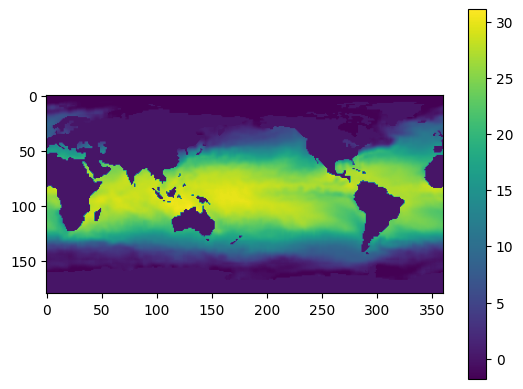

In [4]:
# Plotting a single frame
plt.figure()
plt.imshow(sst_data[0]) 
plt.colorbar()
plt.show()

#### Initialize Data Manager

In [5]:
manager = DataManager(
    lags = 52,
    train_size = 0.8,
    val_size = 0.1,
    test_size = 0.1,
)

#### Add datasets and sensors

In [6]:
manager.add_data(
    data = sst_data,
    id = "SST",
    random = 50,
    # mobile=,
    # stationary=,
    # measurements=,
    compress=False,
)

#### Analyze sensor summary

In [7]:
manager.sensor_summary_df

,data id,number,type,loc/traj
0,SST,0,stationary (random),"(141, 211)"
1,SST,1,stationary (random),"(113, 95)"
2,SST,2,stationary (random),"(179, 325)"
3,SST,3,stationary (random),"(54, 185)"
4,SST,4,stationary (random),"(171, 72)"
5,SST,5,stationary (random),"(29, 1)"
6,SST,6,stationary (random),"(78, 126)"
7,SST,7,stationary (random),"(118, 237)"
8,SST,8,stationary (random),"(177, 60)"
9,SST,9,stationary (random),"(100, 102)"


In [8]:
manager.sensor_measurements_df

data id,SST-0,SST-1,SST-2,SST-3,SST-4,SST-5,SST-6,SST-7,SST-8,SST-9,...,SST-40,SST-41,SST-42,SST-43,SST-44,SST-45,SST-46,SST-47,SST-48,SST-49
0,10.99,24.539999,-0.0,16.180000,-0.0,8.78,27.589999,25.419999,-0.0,28.479999,...,12.04,-0.0,-0.0,-0.26,11.40,28.339999,0.0,19.690000,24.539999,6.78
1,11.04,23.999999,-0.0,16.290000,-0.0,8.67,27.389999,23.869999,-0.0,27.929999,...,11.99,-0.0,-0.0,0.13,11.11,28.249999,0.0,19.660000,24.559999,6.43
2,10.86,24.399999,-0.0,15.800000,-0.0,8.33,27.239999,24.569999,-0.0,28.179999,...,12.08,-0.0,-0.0,0.35,11.21,28.259999,0.0,19.240000,24.949999,5.96
3,10.33,24.399999,-0.0,15.870000,-0.0,8.47,27.019999,24.659999,-0.0,28.279999,...,11.65,-0.0,-0.0,0.57,10.90,28.129999,0.0,19.040000,25.329999,5.91
4,10.91,24.279999,-0.0,15.350000,-0.0,8.54,27.229999,24.159999,-0.0,28.359999,...,11.58,-0.0,-0.0,0.66,10.74,28.359999,0.0,19.510000,25.529999,5.78
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1395,6.92,21.100000,-0.0,23.529999,-0.0,12.98,30.249999,19.870000,-0.0,27.909999,...,16.10,-0.0,-0.0,-1.80,14.48,28.389999,0.0,25.729999,24.939999,13.85
1396,7.32,21.170000,-0.0,23.229999,-0.0,11.99,30.039999,19.990000,-0.0,28.089999,...,15.78,-0.0,-0.0,-1.80,14.11,28.509999,0.0,25.789999,23.649999,13.28
1397,7.82,21.220000,-0.0,22.579999,-0.0,11.58,29.949999,20.350000,-0.0,28.029999,...,14.98,-0.0,-0.0,-1.77,13.61,28.579999,0.0,25.529999,25.569999,12.40
1398,7.70,21.510000,-0.0,22.160000,-0.0,11.08,29.929999,21.360000,-0.0,28.129999,...,14.72,-0.0,-0.0,-1.65,13.75,28.699999,0.0,25.429999,24.839999,12.03


#### Get train, validation, and test set

In [9]:
train_dataset, val_dataset, test_dataset= manager.prepare()

#### Initialize a latent forecaster

In [10]:
latent_lags = 10 # number of timesteps to look back in latent space to build latent sequences
latent_forecaster = LSTM_Forecaster(lags=latent_lags)

#### Initialize SHRED

In [11]:
shred = SHRED(sequence_model="LSTM", decoder_model="SDN", latent_forecaster=latent_forecaster)

#### Fit SHRED

In [12]:
val_errors = shred.fit(train_dataset=train_dataset, val_dataset=val_dataset, num_epochs=10, thres_epoch=20, sindy_regularization=0)
print('val_errors:', val_errors)

Fitting SHRED...
Epoch 1: Average training loss = 0.075075
Validation MSE (epoch 1): 0.038405
Epoch 2: Average training loss = 0.035112
Validation MSE (epoch 2): 0.033361
Epoch 3: Average training loss = 0.030324
Validation MSE (epoch 3): 0.025519
Epoch 4: Average training loss = 0.016844
Validation MSE (epoch 4): 0.011481
Epoch 5: Average training loss = 0.011579
Validation MSE (epoch 5): 0.011419
Epoch 6: Average training loss = 0.011205
Validation MSE (epoch 6): 0.010817
Epoch 7: Average training loss = 0.010458
Validation MSE (epoch 7): 0.010221
Epoch 8: Average training loss = 0.010263
Validation MSE (epoch 8): 0.009860
Epoch 9: Average training loss = 0.009952
Validation MSE (epoch 9): 0.009608
Epoch 10: Average training loss = 0.009570
Validation MSE (epoch 10): 0.009208
val_errors: [0.03840464 0.03336134 0.02551896 0.01148106 0.01141871 0.01081694
 0.01022083 0.00985987 0.00960797 0.00920787]


#### Evaluate SHRED

In [13]:
train_mse = shred.evaluate(dataset=train_dataset)
val_mse = shred.evaluate(dataset=val_dataset)
test_mse = shred.evaluate(dataset=test_dataset)
print(f"Train MSE: {train_mse:.3f}")
print(f"Val   MSE: {val_mse:.3f}")
print(f"Test  MSE: {test_mse:.3f}")

Train MSE: 0.008
Val   MSE: 0.009
Test  MSE: 0.011


#### Initialize SHRED Engine for Downstream Tasks

In [14]:
engine = SHREDEngine(manager, shred)

#### Sensor Measurements to Latent Space

In [15]:
test_latent_from_sensors = engine.sensor_to_latent(manager.test_sensor_measurements)

#### Forecast Latent Space (No Sensor Measurements)

In [16]:
val_latents = engine.sensor_to_latent(manager.val_sensor_measurements)
init_latents = val_latents[-latent_lags:] # seed forecaster with final lag timesteps of latent space from val
t = len(manager.test_sensor_measurements)
test_latent_from_forecaster = engine.forecast_latent(t=t, init_latents=init_latents)

#### Decode Latent Space to Full-State Space

In [17]:
test_prediction = engine.decode(test_latent_from_sensors) # latent space generated from sensor data
test_forecast = engine.decode(test_latent_from_forecaster) # latent space generated from latent forecasted (no sensor data)

Compare final frame in prediction and forecast to ground truth:

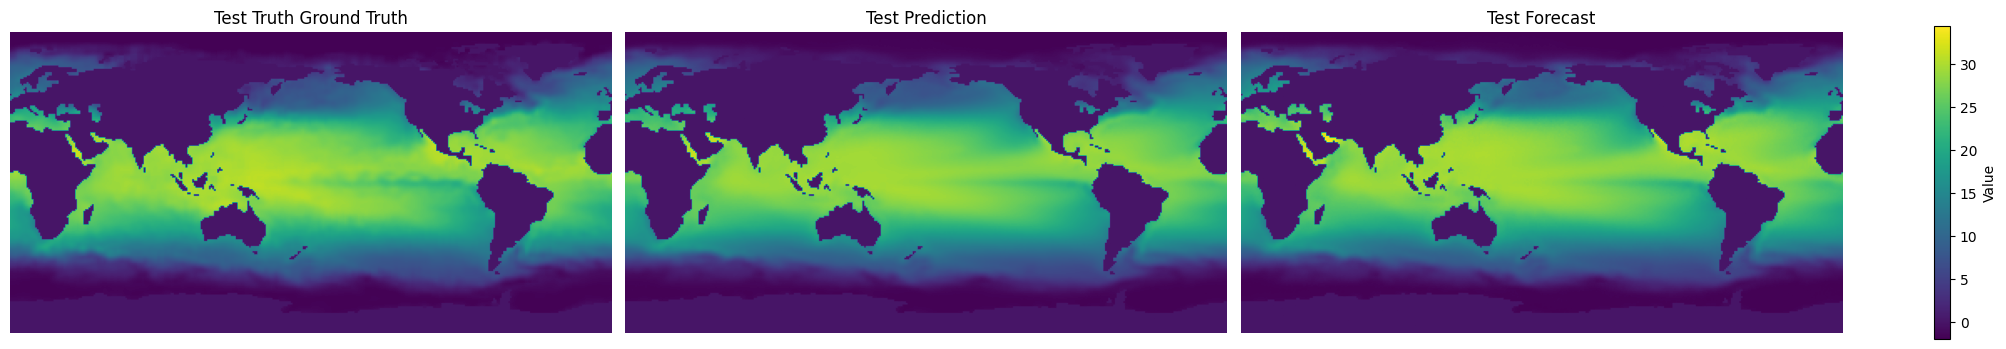

In [18]:
truth      = sst_data[-1]
prediction = test_prediction['SST'][t-1]
forecast   = test_forecast['SST'][t-1]

data   = [truth, prediction, forecast]
titles = ["Test Truth Ground Truth", "Test Prediction", "Test Forecast"]

vmin, vmax = np.min([d.min() for d in data]), np.max([d.max() for d in data])

fig, axes = plt.subplots(1, 3, figsize=(20, 4), constrained_layout=True)

for ax, d, title in zip(axes, data, titles):
    im = ax.imshow(d, vmin=vmin, vmax=vmax)
    ax.set(title=title)
    ax.axis("off")

fig.colorbar(im, ax=axes, label="Value", shrink=0.8)

#### Evaluate MSE on Ground Truth Data

In [19]:
# Train
t_train = len(manager.train_sensor_measurements)
train_Y = {'SST': sst_data[0:t_train]}
train_error = engine.evaluate(manager.train_sensor_measurements, train_Y)

# Val
t_val = len(manager.test_sensor_measurements)
val_Y = {'SST': sst_data[t_train:t_train+t_val]}
val_error = engine.evaluate(manager.val_sensor_measurements, val_Y)

# Test
t_test = len(manager.test_sensor_measurements)
test_Y = {'SST': sst_data[-t_test:]}
test_error = engine.evaluate(manager.test_sensor_measurements, test_Y)

print('---------- TRAIN ----------')
print(train_error)
print('\n---------- VAL   ----------')
print(val_error)
print('\n---------- TEST  ----------')
print(test_error)

---------- TRAIN ----------
              MSE      RMSE       MAE        R2
dataset                                        
SST      0.393446  0.627253  0.364334  0.448413

---------- VAL   ----------
              MSE      RMSE       MAE        R2
dataset                                        
SST      0.466176  0.682771  0.385686 -0.232119

---------- TEST  ----------
              MSE      RMSE       MAE        R2
dataset                                        
SST      0.565816  0.752207  0.438306 -0.531334
